
# EDA

EDA по выбранным репозиториям для построения графа знаний, индексации и последовательной валидации: чтобы оценить размер, состав и структуру кодовой базы и на этой основе точнее настроить индексацию и поиск

**Репозитории:**

- https://github.com/huggingface/pytorch-image-models
- https://github.com/rwightman/pytorch-commands
- https://github.com/alfitranurr/VISION-MEDICINE
- https://github.com/nottyo/football-bot
- https://github.com/subarnasaikia/Tic-Tac-Toe


In [1]:

import os
import subprocess
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline


In [5]:

repos = [
    'https://github.com/huggingface/pytorch-image-models',
    'https://github.com/rwightman/pytorch-commands',
    'https://github.com/alfitranurr/VISION-MEDICINE',
    'https://github.com/nottyo/football-bot',
    'https://github.com/subarnasaikia/Tic-Tac-Toe'
]

base_dir = Path('/Users/tanchiklion/Desktop/CodeAtlas/data/external')
base_dir.mkdir(exist_ok=True)

for url in repos:
    name = url.split('/')[-1]
    repo_path = base_dir / name
    if repo_path.exists():
        print(f"Repository {name} already exists, skipping clone")
        continue
    print(f"Cloning {name}...")
    try:
        subprocess.run(['git', 'clone', '--depth', '1', url, str(repo_path)], check=True)
        print(f"Cloned {name} successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to clone {name}: {e}")


Cloning pytorch-image-models...


Cloning into '/Users/tanchiklion/Desktop/CodeAtlas/data/external/pytorch-image-models'...


Cloned pytorch-image-models successfully.
Cloning pytorch-commands...


Cloning into '/Users/tanchiklion/Desktop/CodeAtlas/data/external/pytorch-commands'...


Cloned pytorch-commands successfully.
Cloning VISION-MEDICINE...


Cloning into '/Users/tanchiklion/Desktop/CodeAtlas/data/external/VISION-MEDICINE'...


Cloned VISION-MEDICINE successfully.
Cloning football-bot...


Cloning into '/Users/tanchiklion/Desktop/CodeAtlas/data/external/football-bot'...


Cloned football-bot successfully.
Cloning Tic-Tac-Toe...


Cloning into '/Users/tanchiklion/Desktop/CodeAtlas/data/external/Tic-Tac-Toe'...


Cloned Tic-Tac-Toe successfully.



## 1. Анализ состава репозитория 

**Собрать базовую статистику:**

- Количество файлов и строк кода по каждому репозиторию
- Распределение файлов по языкам программирования 
- Сколько комментариев 


In [ ]:

def get_language_from_extension(extension):
    ext_map = {
        '.py': 'Python',
        '.cpp': 'C++',
        '.c': 'C',
        '.h': 'C/C++ Header',
        '.hpp': 'C++ Header',
        '.cc': 'C++',
        '.md': 'Markdown',
        '.txt': 'Text',
        '.js': 'JavaScript',
        '.html': 'HTML',
        '.css': 'CSS',
        '.java': 'Java',
        '.cs': 'C#',
        '.makefile': 'Makefile',
        'makefile': 'Makefile'
    }
    ext_lower = extension.lower()
    return ext_map.get(ext_lower, ext_lower.strip('.').upper())


def analyse_repository(repo_path):
    stats = {
        'repo': repo_path.name,
        'total_files': 0,
        'total_lines': 0,
        'comment_lines': 0,
    }
    lang_counts = defaultdict(int)
    lang_lines = defaultdict(int)

    for root, _, files in os.walk(repo_path):
        for file in files:
            file_path = Path(root) / file
            extension = file_path.suffix or file_path.name
            language = get_language_from_extension(extension)
            lang_counts[language] += 1
            stats['total_files'] += 1
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()
                stats['total_lines'] += len(lines)
                lang_lines[language] += len(lines)

                comment_regex = re.compile(r'^\s*(#|//|/\*|\*)')
                stats['comment_lines'] += sum(1 for line in lines if comment_regex.match(line))
            except Exception as e:
                print(f"Skipped {file_path}: {e}")
                continue

    stats['language_counts'] = dict(lang_counts)
    stats['language_lines'] = dict(lang_lines)
    return stats

results = []
for repo_url in repos:
    repo_name = repo_url.split('/')[-1]
    repo_path = base_dir / repo_name
    if not repo_path.exists():
        print(f"Repository {repo_name} was not cloned. Skipping analysis")
        continue
    print(f"Analysing {repo_name}...")
    repo_stats = analyse_repository(repo_path)
    results.append(repo_stats)

overview_df = pd.DataFrame([
    {
        'Repository': r['repo'],
        'Files': r['total_files'],
        'Total lines': r['total_lines'],
        'Comment lines': r['comment_lines'],
        'Comment ratio': (r['comment_lines'] / r['total_lines']) if r['total_lines'] > 0 else 0
    }
    for r in results
])
print("Overview of repositories:")
display(overview_df)


Analysing pytorch-image-models...
Analysing pytorch-commands...
Analysing VISION-MEDICINE...
Analysing football-bot...
Analysing Tic-Tac-Toe...
Overview of repositories:


,Repository,Files,Total lines,Comment lines,Comment ratio
0,pytorch-image-models,479,426277,8333,0.019548
1,pytorch-commands,48,4483,387,0.086326
2,VISION-MEDICINE,178,207640,5348,0.025756
3,football-bot,43,4784,341,0.071279
4,Tic-Tac-Toe,41,1274,357,0.280220



### Визуализация распределения языков


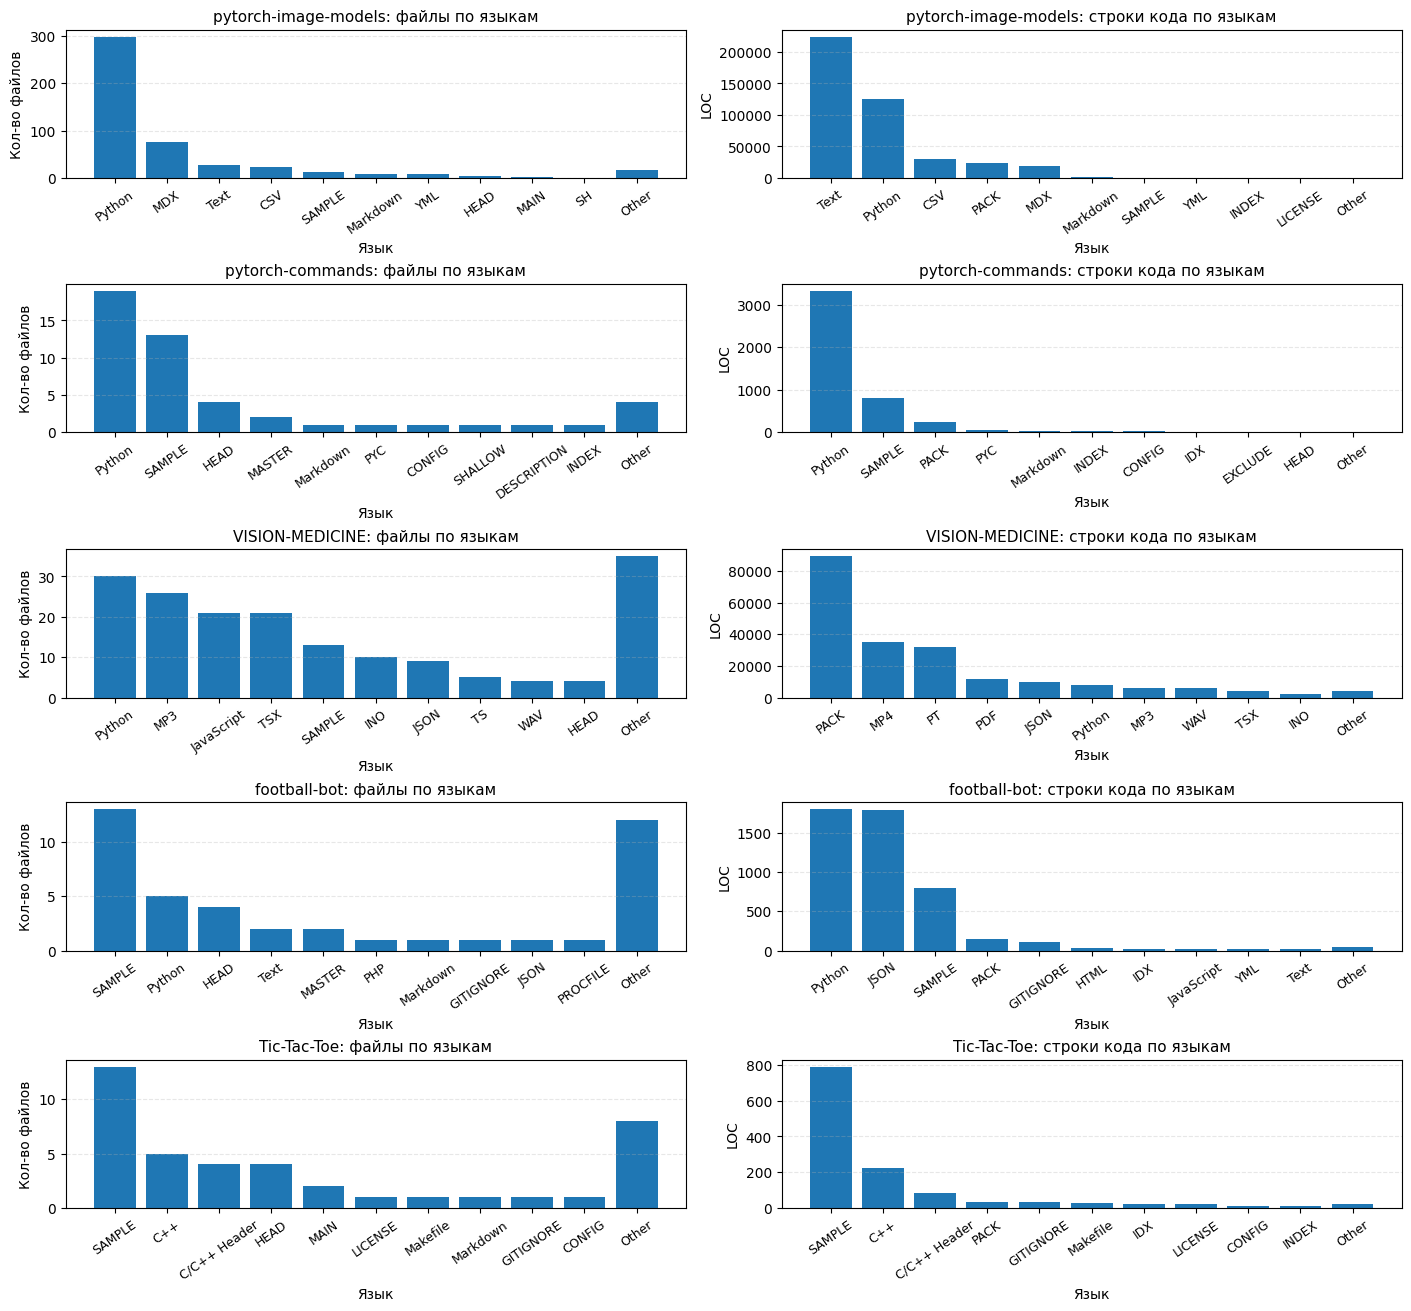

In [10]:
def top_n_with_other(d, n=8, other_label="Other"):
    if not d:
        return {}
    items = sorted(d.items(), key=lambda x: x[1], reverse=True)
    top = items[:n]
    rest = items[n:]
    out = dict(top)
    if rest:
        out[other_label] = sum(v for _, v in rest)
    return out

TOP_N_LANGS = 10
min_bar_value_for_label = 0 

filtered = [r for r in results if r.get("language_counts")]
n = len(filtered)

if n == 0:
    print("Нет данных по языкам")
else:
    fig_h = max(2.6 * n, 6)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(14, fig_h), constrained_layout=True)

    if n == 1:
        axes = [axes]

    for i, repo_stats in enumerate(filtered):
        repo_name = repo_stats["repo"]

        lang_counts = top_n_with_other(repo_stats["language_counts"], n=TOP_N_LANGS)
        lang_lines = top_n_with_other(repo_stats["language_lines"],  n=TOP_N_LANGS)

        ax = axes[i][0]
        keys = list(lang_counts.keys())
        vals = list(lang_counts.values())

        ax.bar(keys, vals)
        ax.set_title(f"{repo_name}: файлы по языкам", fontsize=11)
        ax.set_xlabel("Язык")
        ax.set_ylabel("Кол-во файлов")
        ax.tick_params(axis="x", labelrotation=35, labelsize=9)
        ax.grid(axis="y", linestyle="--", alpha=0.3)

        ax = axes[i][1]
        keys = list(lang_lines.keys())
        vals = list(lang_lines.values())

        ax.bar(keys, vals)
        ax.set_title(f"{repo_name}: строки кода по языкам", fontsize=11)
        ax.set_xlabel("Язык")
        ax.set_ylabel("LOC")
        ax.tick_params(axis="x", labelrotation=35, labelsize=9)
        ax.grid(axis="y", linestyle="--", alpha=0.3)

    plt.show()




### Анализ размеров чанков

Несмотря на то, что планирую использовать AST и построение графа знаний с классами, функциями и тд, проанализирую возможный размер чанков, как запасной вариант.  Поделю файлы на чанки фиксированных размеров по числу строк и получу на получившееся распределение 


In [11]:

def chunk_file(file_path, chunk_size=100, overlap=20):
    chunks = []
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    start = 0
    while start < len(lines):
        end = min(start + chunk_size, len(lines))
        chunk_lines = lines[start:end]
        chunks.append(''.join(chunk_lines))
        if end == len(lines):
            break
        start += (chunk_size - overlap)
    return chunks

chunk_summary = []
for repo_stats in results:
    repo_name = repo_stats['repo']
    repo_path = base_dir / repo_name
    total_chunks = 0
    for root, _, files in os.walk(repo_path):
        for file in files:
            file_path = Path(root) / file
            try:
                if os.path.getsize(file_path) > 1_000_000:
                    continue
                chunks = chunk_file(file_path, chunk_size=100, overlap=20)
                total_chunks += len(chunks)
            except Exception:
                continue
    chunk_summary.append({'Repository': repo_name, 'Total chunks': total_chunks})

chunk_df = pd.DataFrame(chunk_summary)
print("Chunking summary:")
display(chunk_df)


Chunking summary:


,Repository,Total chunks
0,pytorch-image-models,4924
1,pytorch-commands,81
2,VISION-MEDICINE,722
3,football-bot,89
4,Tic-Tac-Toe,44


### Выводы

- Основной объём данных дают pytorch-image-models (~426k строк) и VISION-MEDICINE (~208k) - именно они определяют размер индекса и нагрузку

- В больших репо низкая доля комментариев (~2–3%), значит качество QA сильнее зависит от хорошего retrieval и метаданных, возможно надо будет ллмкой прописывать докстринги

- Определение языка по расширению даёт много шума (SAMPLE/PACK/HEAD/Text/медиа) -> нужен whitelist расширений и фильтрация артефактов

- При chunking 100 строк получаем ~5860 чанков, из них 4924 только в timm -> в MVP объём норм, но лучше перейти на chunking по функциям/классам